In [1]:
'''
Here, we plot PDGrapher performance as a function of the forward data (ablating forward data and seeing whether it stays moreless consistent)
Random splitting. Chemical and Genetic datasets
'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path as osp
from glob import glob
import sys
sys.path.append('../../')
from constants import *
import os
import numpy as np
from scipy import stats


outdir = 'processed'
os.makedirs(outdir, exist_ok = True)
performance = {}

def add_to_performance(df, cell_line, method_name, performance):
    # Populate the dictionary
    for index, row in df.iterrows():
        metric = row['Metric']
        if metric == 'ranking score':
            metric = 'rankings'
        if cell_line not in performance:
            performance[cell_line] = {}
            
        if metric not in performance[cell_line]:
            performance[cell_line][metric] = {method_name: []}

        values = [row['Fold 1'], row['Fold 2'], row['Fold 3'], row['Fold 4'], row['Fold 5']]
        performance[cell_line][metric][method_name] = values
    return performance

In [2]:
performance = {}
for cell_line in ['A549', 'BT20', 'MCF7', 'MDAMB231', 'PC3', 'VCAP']:

    #Loads with/without forward data
    df_no_forward = pd.read_csv('../../../results_metrics_aggregated_bme/no_forward/v2/chemical/{}_drugpred_no_forward_best.csv'.format(cell_line))
    df_original = pd.read_csv('../../../results_metrics_aggregated_bme/perturbagen_pred/v2/PDGrapher/chemical/random/{}_drugpred_within_best.csv'.format(cell_line))

    #Selects only test
    df_no_forward = df_no_forward[df_no_forward['Set'] == 'Test']
    df_original = df_original[df_original['Set'] == 'Test']


    performance = add_to_performance(df_no_forward, cell_line, 'PDGrapher - No disease intervention data', performance)
    performance = add_to_performance(df_original, cell_line, 'PDGrapher', performance)
   

In [3]:
performance['A549'].keys()

dict_keys(['recall@1', 'recall@10', 'recall@100', 'recall@1000', 'percentage of samples with partially accurate predictions', 'rankings', 'ranking score - DCG'])

In [4]:
performance['A549']['recall@1'].keys()

dict_keys(['PDGrapher - No disease intervention data', 'PDGrapher'])

In [5]:
cell_line_to_cancer_type = {
    'A549': 'Lung-A549',
    'A375': 'Skin-A375',
    'BT20': 'Breast-BT20',
    'HELA': 'Cervix-HELA',
    'HT29': 'Colon-HT29',
    'MCF7': 'Breast-MCF7',
    'MDAMB231': 'Breast-MDAMB231',
    'PC3': 'Prostate-PC3',
    'VCAP': 'Prostate-VCAP'
}

In [6]:

# Only include the metrics of interest
metrics_to_include = [
    ("percentage of samples with partially accurate predictions", "Accurately predicted samples (%)", "Panel D"),
]

# Prepare data for each sheet
sheets = {}

for item in metrics_to_include:
    metric, metric_name, panel = item[0], item[1], item[2]
    records = []
    for cell_line in performance:
        if metric not in performance[cell_line]:
            continue
        for model in performance[cell_line][metric]:
            values = performance[cell_line][metric][model]
            for split_index, value in enumerate(values, start=1):
                records.append({
                    "Cell line": cell_line,
                    "Model": model,
                    "Cross-validation split": split_index,
                    metric_name: value
                })
    sheets[panel] = pd.DataFrame(records)


# Save to Excel
with pd.ExcelWriter(osp.join(outdir, "PDGrapher_SourceData_Fig5.xlsx")) as writer:
    for panel, df in sheets.items():
        df.to_excel(writer, sheet_name=panel, index=False)

In [13]:

# Only include the metrics of interest
metrics_to_include = [
    ("ranking score - DCG", "nDCG", 'Panel A')
]

# Prepare data for each sheet
sheets = {}

for item in metrics_to_include:
    metric, metric_name, panel = item[0], item[1], item[2]
    records = []
    for cell_line in performance:
        if metric not in performance[cell_line]:
            continue
        for model in performance[cell_line][metric]:
            values = performance[cell_line][metric][model]
            for split_index, value in enumerate(values, start=1):
                records.append({
                    "Cell line": cell_line,
                    "Model": model,
                    "Cross-validation split": split_index,
                    metric_name: value
                })
    sheets[panel] = pd.DataFrame(records)





# Prepare the recall sheet
recall_metrics = ["recall@1", "recall@10", "recall@100"]
recall_records = []

for cell_line in performance:
    # Check if all recall metrics are present
    if not all(rm in performance[cell_line] for rm in recall_metrics):
        continue

    models = set()
    for rm in recall_metrics:
        models.update(performance[cell_line][rm].keys())

    for model in models:
        for split_index in range(5):
            row = {
                "Cell line": cell_line,
                "Model": model,
                "Cross-validation split": split_index + 1
            }
            for rm in recall_metrics:
                val_list = performance[cell_line][rm].get(model, [None]*5)
                row[rm] = val_list[split_index] if split_index < len(val_list) else None
            recall_records.append(row)



sheets["panel B"] = pd.DataFrame(recall_records)






# Save to Excel
with pd.ExcelWriter(osp.join(outdir, "PDGrapher_Supp_ablation_forward_data_chemical.xlsx")) as writer:
    for panel, df in sheets.items():
        df.to_excel(writer, sheet_name=panel, index=False)

## Panel proportion of partially accurate samples

/tmp/ipykernel_222735/1523307748.py:60: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


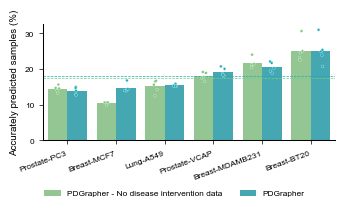

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import font_manager
font_dirs = ['/home/gonzag46/.fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42  # Output Type 42 (TrueType), editable in Illustrator

# Extract the data for 'rankings' into a DataFrame
metric = 'percentage of samples with partially accurate predictions'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()


#Rename cell lines
df['Cancer Type'] = df['Cell Line'].map(cell_line_to_cancer_type)
df_mean['Cancer Type'] = df_mean['Cell Line'].map(cell_line_to_cancer_type)
# Replace x-axis labels with cancer types
df['Cell Line'] = df['Cancer Type']
df_mean['Cell Line'] = df_mean['Cancer Type']



# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define a color palette that matches the existing figures
palette = {
    'PDGrapher - No disease intervention data': '#7FC97F',
    'PDGrapher': '#1AAEBE',
}

# Define the order of methods
method_order = ['PDGrapher - No disease intervention data', 'PDGrapher']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(3.543, 2.19))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.45, -0.55), loc='lower center', ncol=4, frameon=False, title=None)
    plt.xticks(rotation=20, ha="right")
    plt.subplots_adjust(bottom = 0.32, right = 0.95, top = 0.85)
    plt.ylabel('Accurately predicted samples (%)')
    plt.savefig(osp.join(outdir, 'panel_partially_accurate_pred.pdf'))
    plt.show()




## Panel nDCG

/tmp/ipykernel_222735/1502850828.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)


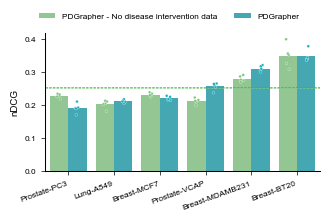

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Extract the data for 'rankings' into a DataFrame
metric = 'ranking score - DCG'
data = []
for cellline, metrics in performance.items():
    if metric in metrics:
        for method, values in metrics[metric].items():
            for value in values:
                data.append([cellline, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Method', metric])

# Calculate the mean 'rankings' for each cell line and method
df_mean = df.groupby(['Cell Line', 'Method']).mean().reset_index()


#Rename cell lines
df['Cancer Type'] = df['Cell Line'].map(cell_line_to_cancer_type)
df_mean['Cancer Type'] = df_mean['Cell Line'].map(cell_line_to_cancer_type)
# Replace x-axis labels with cancer types
df['Cell Line'] = df['Cancer Type']
df_mean['Cell Line'] = df_mean['Cancer Type']


# Order cell lines based on values for PDGrapher
pdgrapher_means = df_mean[df_mean['Method'] == 'PDGrapher'].sort_values(by=metric)
ordered_cell_lines = pdgrapher_means['Cell Line']

# Reorder the DataFrame based on ordered cell lines
df['Cell Line'] = pd.Categorical(df['Cell Line'], categories=ordered_cell_lines, ordered=True)
df_mean['Cell Line'] = pd.Categorical(df_mean['Cell Line'], categories=ordered_cell_lines, ordered=True)

# Define the order of methods
method_order = ['PDGrapher - No disease intervention data', 'PDGrapher']

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(3.543, 2.19))

    # Create a bar plot for each method
    sns.barplot(data=df_mean, x='Cell Line', y=metric, hue='Method', palette=palette, ci=None, hue_order=method_order, alpha=0.9)

    # Overlay individual data points
    sns.stripplot(data=df, x='Cell Line', y=metric, hue='Method', palette=palette, dodge=True, jitter=True, alpha=1.0, hue_order=method_order, size=2, edgecolor="white", linewidth=0.2)





    # Add horizontal lines for the overall mean ranking for each method
    for method in method_order:
        overall_mean = df[df['Method'] == method][metric].mean()
        plt.axhline(y=overall_mean, linestyle='--', color=palette[method], linewidth=0.5)

    # Remove title
    plt.title('')
    plt.ylim

    # Remove X-axis label
    plt.xlabel('')
    sns.despine()

    # Adjust legend to only include the bars and place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    bar_handles = handles[:len(method_order)]
    bar_labels = labels[:len(method_order)]
    plt.legend(bar_handles, bar_labels, bbox_to_anchor=(0.45, 1.2), loc='upper center', ncol=4, frameon=False, title=None)
    plt.xticks(rotation=20, ha="right")
    plt.subplots_adjust(bottom = 0.25)
    plt.ylabel('nDCG')
    plt.savefig(osp.join(outdir, 'panel_ndcg.pdf'))
    plt.show()




## Aggregated recall@k

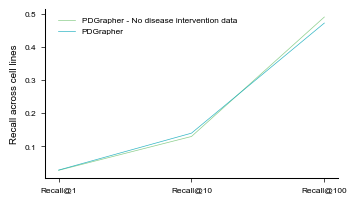

In [10]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize an empty list to store the data
data = []

# Iterate over the performance dictionary to extract all recall metrics
for cellline, metrics in performance.items():
    for metric in ['recall@1', 'recall@10', 'recall@100']:
        if metric in metrics:
            for method, values in metrics[metric].items():
                for value in values:
                    data.append([cellline, metric, method, value])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Cell Line', 'Metric', 'Method', 'Value'])

# Convert the 'Value' column to numeric to avoid any conversion issues
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

# Calculate the mean for each method and metric across all cell lines
df_mean = df.groupby(['Metric', 'Method'])['Value'].mean().reset_index()



# Define the order of methods
method_order = ['PDGrapher - No disease intervention data', 'PDGrapher']
df_mean['Metric'] = [e.capitalize() for e in df_mean['Metric']]

with sns.plotting_context(plotting_context):
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(3.543, 2.19))

    # Create a line plot for each method showing the mean across all cell lines
    sns.lineplot(data=df_mean, x='Metric', y='Value', hue='Method', palette=palette, hue_order=method_order, markers=True, dashes=False, alpha=0.9)

    # Remove X-axis label
    plt.xlabel('')

    sns.despine()

    # Adjust legend to place it at the top
    handles, labels = plt.gca().get_legend_handles_labels()
    line_handles =  handles[:len(method_order)]
    line_labels = labels[:len(method_order)]
    plt.legend(line_handles, line_labels, bbox_to_anchor=(0.35, 1), loc='upper center', ncol=1, frameon=False, title=None)
    # plt.subplots_adjust(top=0.9)
    plt.subplots_adjust(right=0.95)
    # plt.xticks(rotation=20, ha="right")
    plt.ylabel('Recall across cell lines')
    plt.savefig(osp.join(outdir, 'panel_aggregated_mean_recall_metrics.pdf'))
    plt.show()
